# ppo
PPO for discrete actions in TensorFlow development notebook. Full version in RL agents repo.

In [29]:
import gym
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import logging
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import logging
import copy

# env = gym.make('LunarLander-v2')
# env = gym.make('MountainCar-v0')
# env = gym.make('Acrobot-v1')
env = gym.make('CartPole-v1')

tf.random.set_seed(0)
np.random.seed(0)

# memory

In [30]:
class Memory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.advantages = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int32)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                np.array(self.advantages), \
                batches

    def store_memory(self, state, action, probs, vals, reward, done, advantage):
        self.states.extend(state)
        self.actions.extend(action)
        self.probs.extend(probs)
        self.vals.extend(vals)
        self.rewards.extend(reward)
        self.dones.extend(done)
        self.advantages.extend(advantage)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []
        self.advantages = []

In [31]:
class PPO(tf.keras.Model):

    def __init__(self, env, gamma=0.99, training=True):
        super(PPO, self).__init__()

        #         self.fc1 = layers.Dense(512, activation="relu",
        #                                 kernel_initializer=tf.keras.initializers.he_normal(), name="fc1")
        #         self.fc2 = layers.Dense(256, activation="relu",
        #                                 kernel_initializer=tf.keras.initializers.he_normal(), name="fc2")
        #         self.fc3 = layers.Dense(64, activation="relu",
        #                                 kernel_initializer=tf.keras.initializers.he_normal(), name="fc3")

        #         self.actor = layers.Dense(env.action_space.n,
        #                                   kernel_initializer=tf.keras.initializers.he_normal(),
        #                                   activation="linear",
        #                                   name="actor_out")

        #         self.critic = layers.Dense(1, activation="linear", kernel_initializer=tf.keras.initializers.he_normal(), name="critic_out")

        self.actor = tf.keras.Sequential([
            layers.InputLayer(input_shape=(env.observation_space.shape[0],)),
            layers.Dense(512,
                         activation="relu",
                         kernel_initializer=tf.keras.initializers.he_uniform()),
            layers.Dense(256,
                         activation="relu",
                         kernel_initializer=tf.keras.initializers.he_uniform()),
            layers.Dense(64,
                         activation="relu",
                         kernel_initializer=tf.keras.initializers.he_uniform()),
            layers.Dense(env.action_space.n, activation="linear"),
        ])

        self.critic = tf.keras.Sequential([
            layers.InputLayer(input_shape=(env.observation_space.shape[0],)),
            layers.Dense(512,
                         activation="relu",
                         kernel_initializer=tf.keras.initializers.he_uniform()),
            layers.Dense(256,
                         activation="relu",
                         kernel_initializer=tf.keras.initializers.he_uniform()),
            layers.Dense(64,
                         activation="relu",
                         kernel_initializer=tf.keras.initializers.he_uniform()),
            layers.Dense(1, activation="linear")
        ])

        self.env = env
        self.training = training
        self.gamma = gamma

    def call(self, inputs):

        policy_logits = self.actor(inputs)
        dist = tfd.Categorical(logits=policy_logits)
        value = self.critic(inputs)

        #         x = self.fc1(inputs)
        #         x = self.fc2(x)
        #         x = self.fc3(x)
        #         policy_logits = self.actor(x)
        #         dist = tfd.Categorical(logits=policy_logits)
        #         value = self.critic(x)

        return dist, value, policy_logits

In [32]:

def select_action(state, agent, test=False):
    dist, value, policy_logits = agent(tf.expand_dims(state, axis=0))
    
    if test:
        action = np.argmax(tf.squeeze(dist.probs_parameter()).numpy())
    else:
        action = tf.squeeze(dist.sample(1)).numpy()

    return action, tf.squeeze(value), tf.squeeze(policy_logits)


In [33]:
def compute_advantages(values, next_values, rewards, dones):
    
    values = tf.cast(values, dtype=tf.float32)

    deltas = np.zeros((len(rewards)))
    for t, (r, v, nv, d) in enumerate(
            zip(rewards, values.numpy(), next_values.numpy(), dones)):
        deltas[t] = r + GAMMA * (1 - d) * nv - v

    advantages = copy.deepcopy(deltas)
    for t in reversed(range(len(deltas) - 1)):
        advantages[t] = advantages[t] + (
            1 - dones[t]) * GAMMA * GAE_LAMBDA * advantages[t + 1]

    targets = advantages + values

    advantages -= tf.reduce_mean(advantages)
    advantages /= (tf.math.reduce_std(advantages) + 1e-8)
    advantages = tf.cast(advantages, dtype=tf.float32)


    return advantages, targets

In [34]:

EPOCHS = 20
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPS = 0.2

TIMESTEPS = 1000
BATCH_SIZE = 64
N_EPOCHS = 10

C1 = 0.5
C2 = 0.001

agent = PPO(env)
mem = Memory(BATCH_SIZE)
opt = tf.keras.optimizers.Adam(learning_rate = 2.5e-4)

In [35]:
def learn(targets):
    total_loss = 0
    for _ in range(N_EPOCHS):

        states, actions, policy_logits_old, values, rewards, dones, advantages, batches = mem.generate_batches(
        )

        action_idx = tf.stack([tf.range(0, len(rewards)), actions], axis=1)

        old_probs = tf.nn.softmax(tf.squeeze(policy_logits_old))
        old_probs = tf.gather_nd(old_probs, action_idx)

        values = tf.cast(values, dtype=tf.float32)

        for batch in batches:
            with tf.GradientTape() as tape:
                dist, critic_value, policy_logits = agent(states[batch])
                probs = tf.nn.softmax(policy_logits)

                action_idx_batch = tf.stack(
                    [tf.range(0, len(probs)), actions[batch]], axis=1)
                probs = tf.gather_nd(probs, action_idx_batch)

                critic_value = tf.squeeze(critic_value)

                entropy = -tf.reduce_mean(dist.entropy())

                r_theta = tf.math.exp(probs -
                                      tf.squeeze(tf.gather(old_probs, batch)))
                policy_obj = r_theta * tf.gather(advantages, batch)
                clipped_r_theta = tf.clip_by_value(
                    r_theta, 1 - EPS, 1 + EPS) * tf.gather(advantages, batch)

                actor_loss = -tf.reduce_mean(
                    tf.minimum(policy_obj, clipped_r_theta))

                #                 critic_loss = tf.reduce_mean(tf.square(tf.gather(advantages,batch) + tf.gather(values,batch) - critic_value))

                critic_loss = tf.reduce_mean(
                    tf.square(tf.gather(targets, batch) - critic_value))

                # clipped_value_loss = tf.gather(values,batch) + tf.clip_by_value(tf.gather(targets, batch) - tf.gather(values,batch), -0.2, 0.2)
                # v_loss1 = (tf.gather(targets, batch) - clipped_value_loss) ** 2
                # v_loss2 = (tf.gather(targets, batch) - critic_value) ** 2
                # critic_loss = tf.reduce_mean(tf.maximum(v_loss1, v_loss2))

                loss = actor_loss + C1 * critic_loss + C2 * entropy
                total_loss += loss

            # print(f"actor_loss: {actor_loss}, critic_loss: {critic_loss}")
            grads = tape.gradient(loss, agent.trainable_variables)
            opt.apply_gradients(zip(grads, agent.trainable_variables))
    return total_loss


In [36]:
episode_reward_hist = []
loss_hist = []
step = 0
state = env.reset()
done = False
episode_reward = 0
episode = 1

for epoch in range(EPOCHS):
    rewards = []
    actions = []
    values = []
    states = []
    next_states = []
    dones = []
    policy_logits = []

    for t in range(TIMESTEPS):

        action, value, pls = select_action(state, agent)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        actions.append(action)
        values.append(value.numpy())
        rewards.append(reward)
        states.append(state)
        next_states.append(next_state)
        dones.append(done)
        policy_logits.append(pls)

        if done:
            state = env.reset()
            step = 0
            episode_reward_hist.append(episode_reward)
            episode_reward = 0
            episode += 1

        else:
            step += 1
            state = next_state
    _, next_values, _ = agent(np.array(next_states))
    advantages, targets = compute_advantages(values, tf.squeeze(next_values),
                                             rewards, dones)
    mem.store_memory(states, actions, policy_logits, values, rewards, dones,
                     advantages)
    loss = learn(targets)
    loss_hist.append(loss)
    mem.clear_memory()

    if epoch % 1 == 0:
        print(
            f"Epoch: {epoch}, Loss: {loss.numpy():.2f}, Reward: {episode_reward_hist[-1]:.2f}, Mean reward: {np.mean(episode_reward_hist[-50:]):.2f}"
        )
    



Epoch: 0, Loss: 1590.83, Reward: 13.00, Mean reward: 12.92
Epoch: 1, Loss: 2984.73, Reward: 21.00, Mean reward: 21.56
Epoch: 2, Loss: 5542.55, Reward: 187.00, Mean reward: 38.76
Epoch: 3, Loss: 3096.27, Reward: 182.00, Mean reward: 52.14
Epoch: 4, Loss: 3082.51, Reward: 315.00, Mean reward: 71.18
Epoch: 5, Loss: 4919.03, Reward: 500.00, Mean reward: 90.28
Epoch: 6, Loss: 5110.09, Reward: 469.00, Mean reward: 109.20
Epoch: 7, Loss: 1559.30, Reward: 237.00, Mean reward: 125.28
Epoch: 8, Loss: 5468.52, Reward: 500.00, Mean reward: 144.86
Epoch: 9, Loss: 5375.06, Reward: 500.00, Mean reward: 164.34
Epoch: 10, Loss: 4433.48, Reward: 500.00, Mean reward: 183.42
Epoch: 11, Loss: 3410.60, Reward: 500.00, Mean reward: 201.76
Epoch: 12, Loss: 4123.69, Reward: 500.00, Mean reward: 220.90
Epoch: 13, Loss: 1185.01, Reward: 417.00, Mean reward: 237.72
Epoch: 14, Loss: 1671.09, Reward: 283.00, Mean reward: 260.26
Epoch: 15, Loss: 599.27, Reward: 249.00, Mean reward: 274.02
Epoch: 16, Loss: 3214.44, R

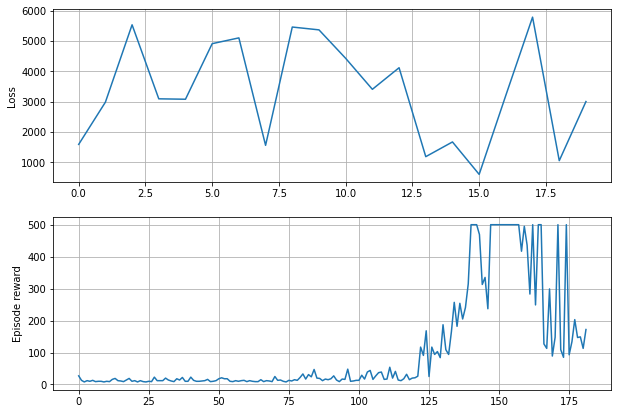

In [37]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(loss_hist)
plt.ylabel("Loss")
plt.grid()
plt.subplot(2,1,2)
plt.plot(episode_reward_hist)
plt.ylabel("Episode reward")
plt.grid()
plt.show();

episode lasted 500 steps. Reward: 500.0


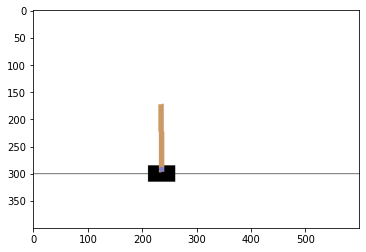

In [39]:
from matplotlib import animation , rc
%matplotlib inline



def render_episode(env, agent, episodes=1, render=True):
    
 
    frame = []

    
    for episode in range(episodes):

        step = 0
        state = env.reset() #list(env.decode(env.reset()))
        done = False
        episode_reward = 0

        # play and record in memory
        while not done:
            step += 1
            action, _, _ = select_action(state, agent, test=True)

            new_state, reward, done, info = env.step(action)
            if render:
                img = plt.imshow(env.render('rgb_array'))
                frame.append([img])

            if done:
                state = env.reset() 
            else:
                state = new_state
            episode_reward += reward

        print(f"episode lasted {step} steps. Reward: {episode_reward}")
    return frame
    
# Save GIF image
fig = plt.figure()
images = render_episode(env, agent, episodes = 1, render=True)

an = animation.ArtistAnimation(fig, images, interval=100, repeat_delay=1000, blit=True)
rc('animation', html='jshtml')

f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
an.save(f, writer=writergif)